In [38]:
# Connect to Google Drive 
# Upload the dataset to your Google drive so it can be loaded here

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io
import re
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 
K.clear_session()

# Check tensorflow version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


In [40]:
# import pandas lib as pd
import pandas as pd
 
# read by default 1st sheet of an excel file
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Testing FNH dataset/RandomOverSampler_withFeatures.xlsx', 'Sheet1')
 
print(df)
df = df.fillna(' ')
df.count()

                                                   Title    Len  \
0      White house asks congress for funding on afgha...   3192   
1      Fear of ebola as congolese caught crossing us-...   1315   
2      Sunday screening: better brain health: we are ...   1095   
3                                Trump's weird fed tweet  14123   
4      States pushing back january enrollment deadlin...    233   
...                                                  ...    ...   
14860  Worrying new coronavirus variants aren't just ...  10096   
14861  Lawmakers respond to industry outcry with flex...   1085   
14862  Senate dems to try to stop doj's funding for o...   1914   
14863  Tn primary heats up: name calling and attack a...   2798   
14864  Many considering getting a shingle shot opting...    118   

                                                 Content  \
0      President joe biden's aides on tuesday asked c...   
1      A public health official in laredo, texas, sai...   
2      It appea

Title      14865
Len        14865
Content    14865
Source     14865
Smog       14865
TTR        14865
Label      14865
dtype: int64

In [41]:
# Normalize the dataset
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

df['Content'] = normalize(df['Content'])

In [42]:
# Tokenize text

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Content'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

# Padding data

sequences = tokenizer.texts_to_sequences(df['Content'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

90999


# **Different Activation Functions with Split Ratio of Data = 80:20**

In [43]:
# Spliting data - withom random shuffle
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['Label'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['Label'].values[split_n:]

print("Train label","/n",train_labels)
print("/nTest label","/n",test_labels)

print(type(train_data))
print(len(train_data))
print(type(train_labels))
print(len(train_labels))

Train label /n [0 1 1 ... 1 1 0]
/nTest label /n [1 0 0 ... 0 1 1]
<class 'numpy.ndarray'>
11892
<class 'numpy.ndarray'>
11892


In [44]:
# Import tensor representations for words - GloVe Embedding
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/content/drive/MyDrive/Colab Notebooks/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))

embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2023-02-18 15:52:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-18 15:52:22 ERROR 404: Not Found.

100


**Model with Activation Function = Relu**

In [45]:
# Build the architecture of the RNN model - Activation Function = Relu
     
model_relu = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20), 
    tf.keras.layers.Dense(512), 
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [46]:
model_relu.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_relu.summary()

history_relu = model_relu.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         9100000   
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, None, 20)          6800      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dense (Dense)               (None, 512)               10752     
                                                        

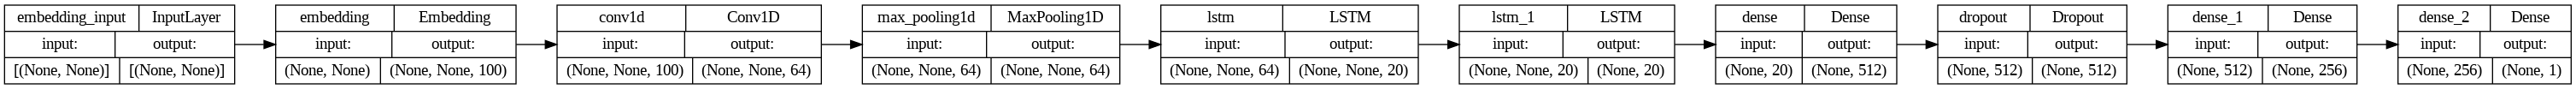

In [47]:
tf.keras.utils.plot_model(model_relu, show_shapes=True, rankdir="LR")

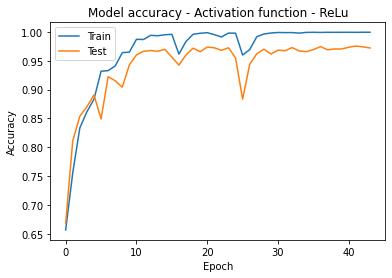

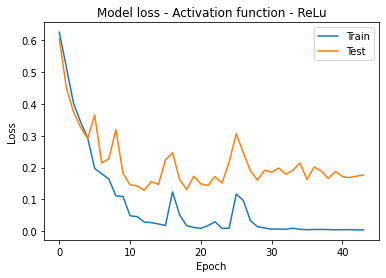

In [48]:
# Visualize the results:

plt.plot(history_relu.history['accuracy'])
plt.plot(history_relu.history['val_accuracy'])
plt.title('Model accuracy - Activation function - ReLu')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_relu.history['loss'])
plt.plot(history_relu.history['val_loss'])
plt.title('Model loss - Activation function - ReLu')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [49]:
pred_relu = model_relu.predict(test_data)

binary_predictions_relu = []

for i in pred_relu:
    if i >= 0.5:
        binary_predictions_relu.append(1)
    else:
        binary_predictions_relu.append(0) 

93/93 [==============================] - 1s 5ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

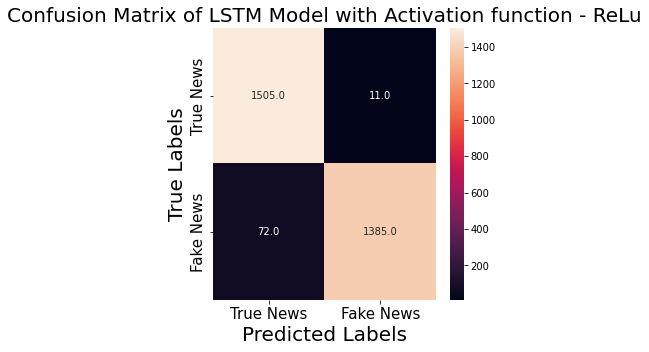

In [50]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_relu, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix of LSTM Model with Activation function - ReLu', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15) 

In [51]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_relu = metrics.accuracy_score(test_labels, binary_predictions_relu)
Precision_relu = metrics.precision_score(test_labels, binary_predictions_relu)
Sensitivity_recall_relu = metrics.recall_score(test_labels, binary_predictions_relu)
Specificity_relu = metrics.recall_score(test_labels, binary_predictions_relu, pos_label=0)
F1_score_relu = metrics.f1_score(test_labels, binary_predictions_relu)

print("Accuracy of LSTM Model - Activation function - ReLu =", Accuracy_relu)
print("Precision of LSTM Model - Activation function - ReLu =", Precision_relu)
print("Sensitivity_recall of LSTM Model - Activation function - ReLu =", Sensitivity_recall_relu)
print("Specificity of LSTM Model - Activation function - ReLu =", Specificity_relu)
print("F1_score of LSTM Model - Activation function - ReLu =", F1_score_relu)


Accuracy of LSTM Model - Activation function - ReLu = 0.9720820719811638
Precision of LSTM Model - Activation function - ReLu = 0.9505833905284832
Sensitivity_recall of LSTM Model - Activation function - ReLu = 0.9921203438395415
Specificity of LSTM Model - Activation function - ReLu = 0.9543436905516804
F1_score of LSTM Model - Activation function - ReLu = 0.9709078163336838


**Model with Activation function = tanh**

In [52]:
# Build the architecture of the RNN model - Activation Function = tanh
     
model_tanh = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='tanh'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [53]:
model_tanh.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_tanh.summary()

history_tanh = model_tanh.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_1 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, None, 20)          6800      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3280      
                                                                 
 dense_3 (Dense)             (None, 512)               10752     
                                                      

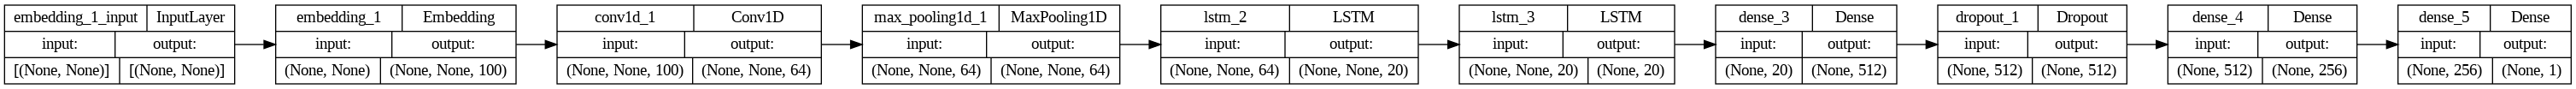

In [54]:
tf.keras.utils.plot_model(model_tanh, show_shapes=True, rankdir="LR")

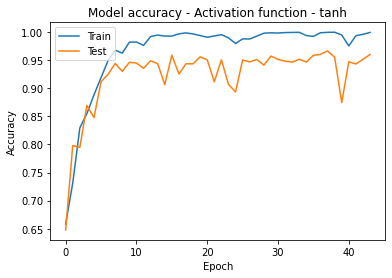

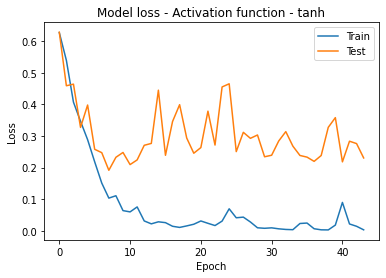

In [55]:
# Visualize the results:

plt.plot(history_tanh.history['accuracy'])
plt.plot(history_tanh.history['val_accuracy'])
plt.title('Model accuracy - Activation function - tanh')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_tanh.history['loss'])
plt.plot(history_tanh.history['val_loss'])
plt.title('Model loss - Activation function - tanh')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [56]:
pred_tanh = model_tanh.predict(test_data)

binary_predictions_tanh = []

for i in pred_tanh:
    if i >= 0.5:
        binary_predictions_tanh.append(1)
    else:
        binary_predictions_tanh.append(0) 

93/93 [==============================] - 1s 5ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

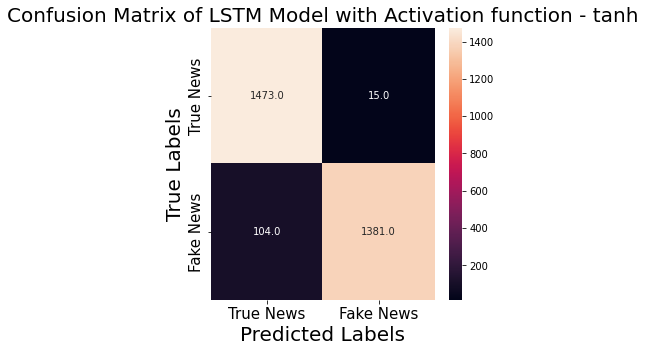

In [57]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_tanh, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix of LSTM Model with Activation function - tanh', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [58]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_tanh = metrics.accuracy_score(test_labels, binary_predictions_tanh)
Precision_tanh = metrics.precision_score(test_labels, binary_predictions_tanh)
Sensitivity_recall_tanh = metrics.recall_score(test_labels, binary_predictions_tanh)
Specificity_tanh = metrics.recall_score(test_labels, binary_predictions_tanh, pos_label=0)
F1_score_tanh = metrics.f1_score(test_labels, binary_predictions_tanh)

print("Accuracy of LSTM Model - Activation function - tanh =", Accuracy_tanh)
print("Precision of LSTM Model - Activation function - tanh =", Precision_tanh)
print("Sensitivity_recall of LSTM Model - Activation function - tanh =", Sensitivity_recall_tanh)
print("Specificity of Model - Activation function - tanh =", Specificity_tanh)
print("F1_score of LSTM Model - Activation function - tanh =", F1_score_tanh)

Accuracy of LSTM Model - Activation function - tanh = 0.9599730911537168
Precision of LSTM Model - Activation function - tanh = 0.92996632996633
Sensitivity_recall of LSTM Model - Activation function - tanh = 0.9892550143266475
Specificity of Model - Activation function - tanh = 0.9340519974635384
F1_score of LSTM Model - Activation function - tanh = 0.9586948976049983


**Model with Activation function = Sigmoid**

In [59]:
# Build the architecture of the RNN model - Activation Function = sigmoid
     
model_sigmoid = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='sigmoid'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [60]:
model_sigmoid.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_sigmoid.summary()

history_sigmoid = model_sigmoid.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, None, 20)          6800      
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dense_6 (Dense)             (None, 512)               10752     
                                                      

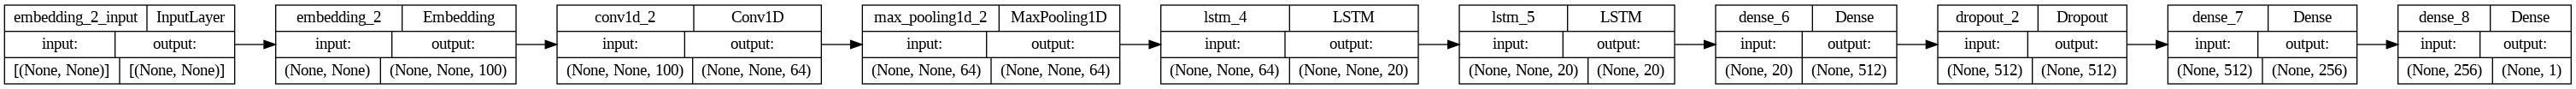

In [61]:
tf.keras.utils.plot_model(model_sigmoid, show_shapes=True, rankdir="LR")

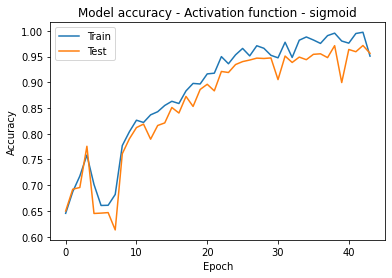

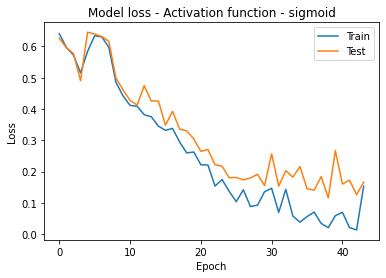

In [62]:
# Visualize the results:

plt.plot(history_sigmoid.history['accuracy'])
plt.plot(history_sigmoid.history['val_accuracy'])
plt.title('Model accuracy - Activation function - sigmoid')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_sigmoid.history['loss'])
plt.plot(history_sigmoid.history['val_loss'])
plt.title('Model loss - Activation function - sigmoid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [63]:
pred_sigmoid = model_sigmoid.predict(test_data)

binary_predictions_sigmoid = []

for i in pred_sigmoid:
    if i >= 0.5:
        binary_predictions_sigmoid.append(1)
    else:
        binary_predictions_sigmoid.append(0) 

93/93 [==============================] - 1s 5ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

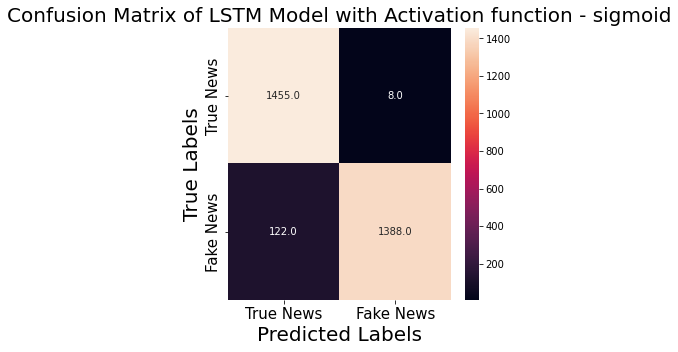

In [64]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_sigmoid, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix of LSTM Model with Activation function - sigmoid', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [65]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_sigmoid = metrics.accuracy_score(test_labels, binary_predictions_sigmoid)
Precision_sigmoid = metrics.precision_score(test_labels, binary_predictions_sigmoid)
Sensitivity_recall_sigmoid = metrics.recall_score(test_labels, binary_predictions_sigmoid)
Specificity_sigmoid = metrics.recall_score(test_labels, binary_predictions_sigmoid, pos_label=0)
F1_score_sigmoid = metrics.f1_score(test_labels, binary_predictions_sigmoid)

print("Accuracy of LSTM Model - Activation function - sigmoid =", Accuracy_sigmoid)
print("Precision of LSTM Model - Activation function - sigmoid =", Precision_sigmoid)
print("Sensitivity_recall of LSTM Model - Activation function - sigmoid) =", Sensitivity_recall_sigmoid)
print("Specificity of LSTM Model - Activation function - sigmoid =", Specificity_sigmoid)
print("F1_score of LSTM Model - Activation function - sigmoid =", F1_score_sigmoid)

Accuracy of LSTM Model - Activation function - sigmoid = 0.9562731247897747
Precision of LSTM Model - Activation function - sigmoid = 0.919205298013245
Sensitivity_recall of LSTM Model - Activation function - sigmoid) = 0.994269340974212
Specificity of LSTM Model - Activation function - sigmoid = 0.9226379201014585
F1_score of LSTM Model - Activation function - sigmoid = 0.9552649690295939


**Model with Activation function = Softmax**

In [66]:
# Build the architecture of the RNN model - Activation Function = softmax
     
model_softmax = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Conv1D(64, 5, activation='sigmoid'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [67]:
model_softmax.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_softmax.summary()

history_softmax = model_softmax.fit(train_data, train_labels, epochs=44, batch_size=200, validation_data=[test_data, test_labels])

print("Training Complete")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         9100000   
                                                                 
 conv1d_3 (Conv1D)           (None, None, 64)          32064     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, None, 20)          6800      
                                                                 
 lstm_7 (LSTM)               (None, 20)                3280      
                                                                 
 dense_9 (Dense)             (None, 512)               10752     
                                                      

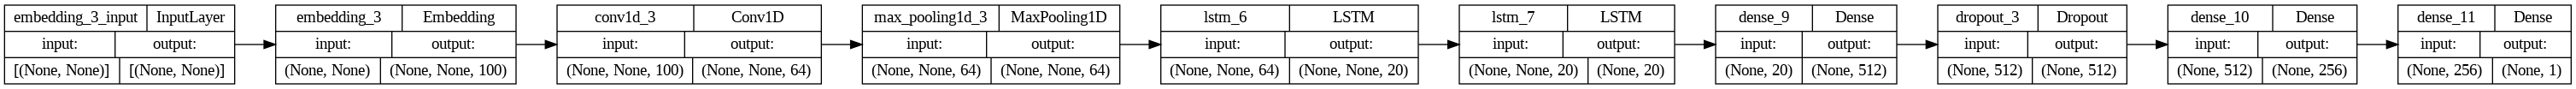

In [68]:
tf.keras.utils.plot_model(model_softmax, show_shapes=True, rankdir="LR")

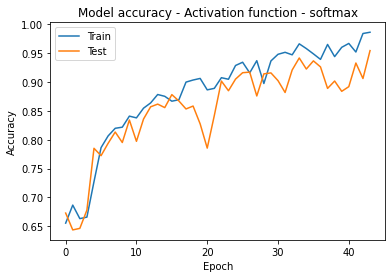

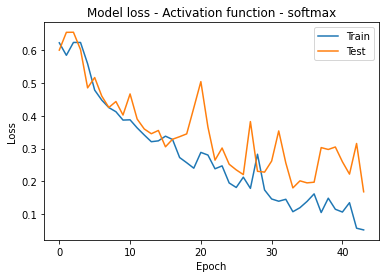

In [69]:
# Visualize the results:

plt.plot(history_softmax.history['accuracy'])
plt.plot(history_softmax.history['val_accuracy'])
plt.title('Model accuracy - Activation function - softmax')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_softmax.history['loss'])
plt.plot(history_softmax.history['val_loss'])
plt.title('Model loss - Activation function - softmax')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [70]:
pred_softmax = model_softmax.predict(test_data)

binary_predictions_softmax = []

for i in pred_softmax:
    if i >= 0.5:
        binary_predictions_softmax.append(1)
    else:
        binary_predictions_softmax.append(0) 

93/93 [==============================] - 1s 5ms/step


[Text(0, 0.5, 'True News'), Text(0, 1.5, 'Fake News')]

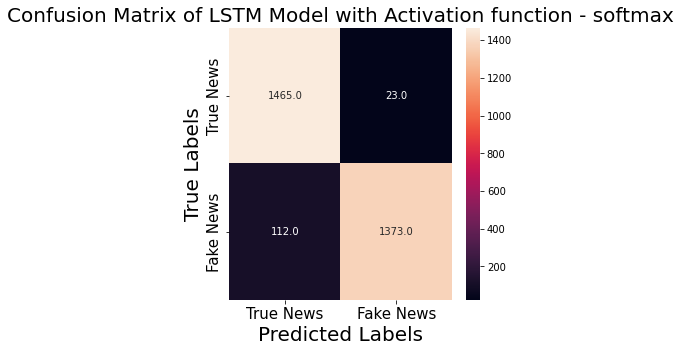

In [71]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(binary_predictions_softmax, test_labels)
plt.figure(figsize=(5, 5))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt = ".1f")

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix of LSTM Model with Activation function - softmax', size=20) 
ax.xaxis.set_ticklabels(['True News','Fake News'], size=15)
ax.yaxis.set_ticklabels(['True News','Fake News'], size=15)

In [72]:
# Precision, recall, accuracy score and F1 score

from sklearn import metrics
Accuracy_softmax = metrics.accuracy_score(test_labels, binary_predictions_softmax)
Precision_softmax = metrics.precision_score(test_labels, binary_predictions_softmax)
Sensitivity_recall_softmax = metrics.recall_score(test_labels, binary_predictions_softmax)
Specificity_softmax = metrics.recall_score(test_labels, binary_predictions_softmax, pos_label=0)
F1_score_softmax = metrics.f1_score(test_labels, binary_predictions_softmax)

print("Accuracy of LSTM Model - Activation function - softmax =", Accuracy_softmax)
print("Precision of LSTM Model - Activation function - softmax =", Precision_softmax)
print("Sensitivity_recall of LSTM Model - Activation function - softmax) =", Sensitivity_recall_softmax)
print("Specificity of LSTM Model - Activation function - softmax =", Specificity_softmax)
print("F1_score of LSTM Model - Activation function - softmax =", F1_score_softmax)

Accuracy of LSTM Model - Activation function - softmax = 0.9545913218970736
Precision of LSTM Model - Activation function - softmax = 0.9245791245791246
Sensitivity_recall of LSTM Model - Activation function - softmax) = 0.9835243553008596
Specificity of LSTM Model - Activation function - softmax = 0.9289790741915028
F1_score of LSTM Model - Activation function - softmax = 0.9531412703922248


**Combination of All the Results**

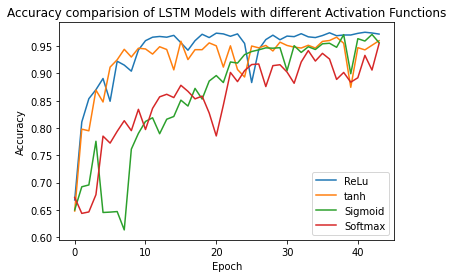

In [73]:
plt.plot(history_relu.history['val_accuracy'])
plt.plot(history_tanh.history['val_accuracy'])
plt.plot(history_sigmoid.history['val_accuracy'])
plt.plot(history_softmax.history['val_accuracy'])
plt.title('Accuracy comparision of LSTM Models with different Activation Functions')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ReLu', 'tanh', 'Sigmoid', 'Softmax'], loc='lower right')
plt.show()

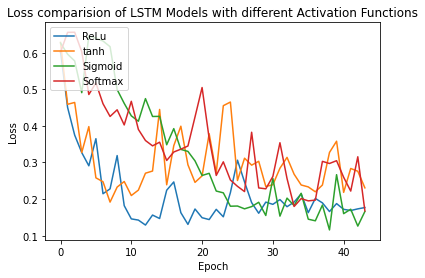

In [74]:
plt.plot(history_relu.history['val_loss'])
plt.plot(history_tanh.history['val_loss'])
plt.plot(history_sigmoid.history['val_loss'])
plt.plot(history_softmax.history['val_loss'])
plt.title('Loss comparision of LSTM Models with different Activation Functions')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ReLu', 'tanh', 'Sigmoid', 'Softmax'], loc='upper left')
plt.show()